### Imports for plotting

In [56]:
#-----------------------Setup For Plotting---------------------------

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np 
import pickle
import itertools

from plotting_helpers import *
from ga_util_objects import *
from config import *

PROBLEM = ['LR', 'KM_4', 'KM_16'] 
DATA_PATH = 'processed_datasets/'
DATASETS=['Adult', 'Credit', 'Spam', 'Mushrooms']
utils = {}
for problem in PROBLEM:
    for dataset_filename in DATASETS:
        with open(DATA_PATH + dataset_filename +'.p', 'rb') as input_file:
            data_object = pickle.load(input_file)
        if problem == 'KM_4':
            util_obj = K_Median(data_object['clustering_sets']['public'],
                                            data_object['clustering_sets']['private'],
                                            4)
        elif problem == 'KM_16':
            util_obj = K_Median(data_object['clustering_sets']['public'],
                                            data_object['clustering_sets']['private'],
                                            16)
        elif problem == 'LR':
            util_obj = Log_Regression(data_object['test_train_sets']['test_x'], 
                        data_object['test_train_sets']['test_y'], 
                )
        utils[dataset_filename + problem] = util_obj

#Prepping baselines
baseline = {}
for problem in PROBLEM:
    for dataset in DATASETS:
        if problem == 'LR':
            baseline[dataset + problem] = utils[dataset+problem].get_utility(np.zeros(utils[dataset+problem].cand_size))
        else:
            candidates = utils[dataset+problem].get_initial_pop(1000, 1e-6, np.random.default_rng())
            baseline[dataset+problem] = np.mean(utils[dataset+problem].get_utility_all(candidates))

with open('misc_p_files/our_final_best.p', 'rb') as input_file:
            our_best = pickle.load(input_file)

with open('misc_p_files/non_private_baselines.p', 'rb') as input_file:
            non_priv_baseline = pickle.load(input_file)
if not os.path.exists('Plots/Sup_plots/'):
    os.makedirs('Plots/Sup_plots/')

Loading distance matrix from cache
Loading distance matrix from cache
Loading distance matrix from cache
Loading distance matrix from cache
Loading distance matrix from cache
Loading distance matrix from cache
Loading distance matrix from cache
Loading distance matrix from cache


In [57]:
#-------------Function to create result dictionaries----------------------------
def get_results_and_dump(result_path, result_name, out_name, datasets=DATASETS, problems=PROBLEM, bug=False, simple=False, REFRESH=False):
    ci_dict = {}
    if os.path.exists('Result_Dicts/{}'.format(out_name)) and not REFRESH:
        with open('Result_Dicts/{}'.format(out_name), 'rb') as input_file:
            ci_dict = pickle.load(input_file)
    else:
        for problem in problems:
            for dataset in datasets:
                if bug:
                    results = file_reader('{}{}/'.format(result_path, dataset), problem+result_name)
                else:
                    results = file_reader('{}{}/{}/'.format(result_path, dataset, problem), result_name)
                if simple:
                    performance = compute_final_utilities_simple(results, utils[dataset+problem])
                else:
                    performance = compute_final_utilities(results, utils[dataset+problem], performance=False)
                ci_dict[dataset+problem] = get_CI(performance)
        with open('Result_Dicts/{}'.format(out_name), "wb") as outfile:
            pickle.dump(ci_dict, outfile)
    return ci_dict
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

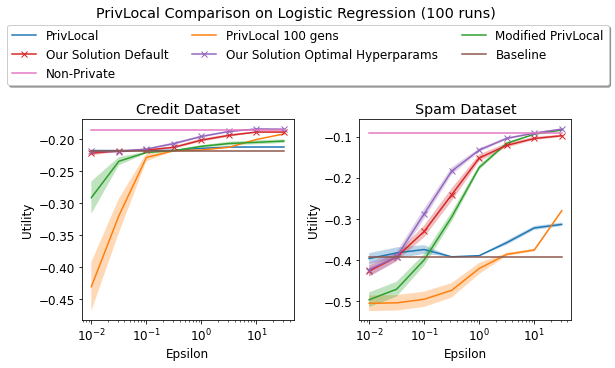

<Figure size 432x288 with 0 Axes>

In [58]:
priv_local_ci_dict = get_results_and_dump('Priv_Local/', 'PrivLocal', 'PrivLocal.p', problems=['LR'], bug=True)
priv_local_mod_ci_dict = get_results_and_dump('Priv_Local_MOD/', 'PrivLocal', 'PrivLocal_mod.p', problems=['LR'])
plt.rcParams.update({'font.size': 12})
epsilons = GENS_EPS
nice_names = {'KM':'K-Median', 'LR':'Logistic Regression'}
for problem in ['LR']:
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
    fig.suptitle("PrivLocal Comparison on {} (100 runs)\n\n\n".format(nice_names[problem]), y=1.02)
    for i, dataset in enumerate(['Credit', 'Spam']):
        result = priv_local_ci_dict[dataset+problem]['0']
        values = [result[str(eps)][0] for eps in epsilons]
        axs[i].semilogx(epsilons, values, label='PrivLocal')
        lower = [result[str(eps)][1] for eps in epsilons]
        upper = [result[str(eps)][2] for eps in epsilons]
        axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
        result = priv_local_ci_dict[dataset+problem]['100']
        values = [result[str(eps)][0] for eps in epsilons]
        axs[i].semilogx(epsilons, values, label='PrivLocal 100 gens')
        lower = [result[str(eps)][1] for eps in epsilons]
        upper = [result[str(eps)][2] for eps in epsilons]
        axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
        result = priv_local_mod_ci_dict[dataset+problem]['100']
        values = [result[str(eps)][0] for eps in epsilons]
        axs[i].semilogx(epsilons, values, label='Modified PrivLocal')
        lower = [result[str(eps)][1] for eps in epsilons]
        upper = [result[str(eps)][2] for eps in epsilons]
        axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
        axs[i].semilogx(epsilons, our_best['default'][dataset+problem][0][:-1], label='Our Solution Default', marker='x')
        axs[i].fill_between(epsilons, our_best['default'][dataset+problem][1][:-1], our_best['default'][dataset+problem][2][:-1], alpha=0.3)
        axs[i].semilogx(epsilons, our_best['optimal'][dataset+problem][0][:-1], label='Our Solution Optimal Hyperparams', marker='x')
        axs[i].fill_between(epsilons, our_best['optimal'][dataset+problem][1][:-1], our_best['optimal'][dataset+problem][2][:-1], alpha=0.3)
        axs[i].semilogx(epsilons, [baseline[dataset+problem]] * len(epsilons), label='Baseline')
        axs[i].semilogx(epsilons, [non_priv_baseline[dataset+problem]] * len(epsilons), label='Non-Private')
        axs[i].set_title("{} Dataset".format(dataset))
        axs[i].set_xlabel("Epsilon")
        axs[i].set_ylabel("Utility")
    fig.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(flip(handles,3), flip(labels,3), loc='upper center', bbox_to_anchor=(0.52, 0.97),
        fancybox=True, shadow=True, borderaxespad=0, ncol=3)
    plt.plot()
    plt.savefig('Plots/Sup_plots/priv_local_{}.png'.format(problem), bbox_inches='tight')
    fig.tight_layout()
    plt.show()
    plt.clf()

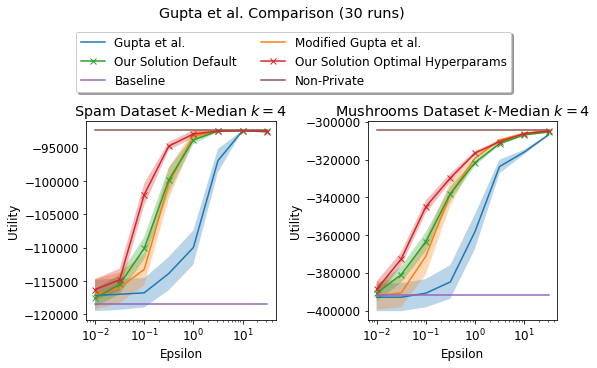

<Figure size 432x288 with 0 Axes>

In [59]:
gupta_local_ci_dict = get_results_and_dump('Gupta_Local_Final/', 'GuptaLocal', 'GuptaLocal.p', problems=['KM_4', 'KM_16'], datasets=['Spam', 'Mushrooms'], bug=True, simple=True)
gupta_local_mod_ci_dict = get_results_and_dump('Gupta_Local_Final_MOD/', 'GuptaLocal', 'GuptaLocal_mod.p', problems=['KM_4', 'KM_16'], datasets=['Spam', 'Mushrooms'], simple=True)
plt.rcParams.update({'font.size': 12})
epsilons = GENS_EPS
nice_names = {'KM_4':'$k$-Median $k=4$', 'KM_16':'$k$-Median $k=16$','LR':'Logistic Regression'}
subplot_config = [('Spam', 'KM_4'), ('Mushrooms', 'KM_4')]#, ('Spam', 'KM_16'), ('Mushrooms', 'KM_16')]

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
fig.suptitle("Gupta et al. Comparison (30 runs)\n\n\n", y=1.02)
for i in range(2):
    dataset, problem = subplot_config[i]
    result = gupta_local_ci_dict[dataset+problem]
    values = [result[str(eps)][0] for eps in epsilons]
    axs[i].semilogx(epsilons, values, label='Gupta et al.')
    lower = [result[str(eps)][1] for eps in epsilons]
    upper = [result[str(eps)][2] for eps in epsilons]
    axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
    result = gupta_local_mod_ci_dict[dataset+problem]
    values = [result[str(eps)][0] for eps in epsilons]
    axs[i].semilogx(epsilons, values, label='Modified Gupta et al.')
    lower = [result[str(eps)][1] for eps in epsilons]
    upper = [result[str(eps)][2] for eps in epsilons]
    axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
    axs[i].semilogx(epsilons, our_best['default'][dataset+problem][0][:-1], label='Our Solution Default', marker='x')
    axs[i].fill_between(epsilons, our_best['default'][dataset+problem][1][:-1], our_best['default'][dataset+problem][2][:-1], alpha=0.3)
    axs[i].semilogx(epsilons, our_best['optimal'][dataset+problem][0][:-1], label='Our Solution Optimal Hyperparams', marker='x')
    axs[i].fill_between(epsilons, our_best['optimal'][dataset+problem][1][:-1], our_best['optimal'][dataset+problem][2][:-1], alpha=0.3)
    axs[i].semilogx(epsilons, [baseline[dataset+problem]] * len(epsilons), label='Baseline')
    axs[i].semilogx(epsilons, [non_priv_baseline[dataset+problem]] * len(epsilons), label='Non-Private')
    axs[i].set_title("{} Dataset {}".format(dataset, nice_names[problem]))
    axs[i].set_xlabel("Epsilon")
    axs[i].set_ylabel("Utility")
    fig.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(flip(handles,2), flip(labels,2), loc='upper center', bbox_to_anchor=(0.52, 0.95),
        fancybox=True, shadow=True, borderaxespad=0, ncol=2)
plt.plot()
plt.savefig('Plots/Sup_plots/gupta_local.png', bbox_inches='tight')
fig.tight_layout()
plt.show()
plt.clf()

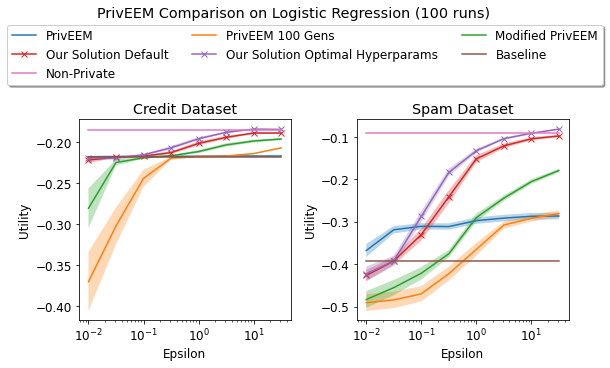

<Figure size 432x288 with 0 Axes>

In [60]:
epsilons = GENS_EPS
ci_dict = get_results_and_dump('PrivGene_Experiment/', 'PrivGene', 'PrivGene.p', problems=['LR'])
privEEM_MOD_ci_dict = get_results_and_dump('Priv_eem_MOD/', 'PrivEEM', 'PrivEEM_MOD.p', problems=['LR'])
plt.rcParams.update({'font.size': 12})
nice_names = {'KM_4':'$k$-Median $k=4$', 'KM_16':'$k$-Median $k=16$','LR':'Logistic Regression'}
problem='LR'
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
fig.suptitle("PrivEEM Comparison on {} (100 runs)\n\n\n".format(nice_names[problem]), y=1.02)
for i, dataset in enumerate(['Credit','Spam']):
    result = ci_dict[dataset+problem]['eem']['0']
    values = [result[str(eps)][0] for eps in epsilons]
    axs[i].semilogx(epsilons, values, label='{}'.format('PrivEEM'))
    lower = [result[str(eps)][1] for eps in epsilons]
    upper = [result[str(eps)][2] for eps in epsilons]
    axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
    result = ci_dict[dataset+problem]['eem']['100']
    values = [result[str(eps)][0] for eps in epsilons]
    axs[i].semilogx(epsilons, values, label='{}'.format('PrivEEM 100 Gens'))
    lower = [result[str(eps)][1] for eps in epsilons]
    upper = [result[str(eps)][2] for eps in epsilons]
    axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
    result = privEEM_MOD_ci_dict[dataset+problem]['100']
    values = [result[str(eps)][0] for eps in epsilons]
    axs[i].semilogx(epsilons, values, label='{}'.format('Modified PrivEEM'))
    lower = [result[str(eps)][1] for eps in epsilons]
    upper = [result[str(eps)][2] for eps in epsilons]
    axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
    axs[i].semilogx(epsilons, our_best['default'][dataset+problem][0][:-1], label='Our Solution Default', marker='x')
    axs[i].fill_between(epsilons, our_best['default'][dataset+problem][1][:-1], our_best['default'][dataset+problem][2][:-1], alpha=0.3)
    axs[i].semilogx(epsilons, our_best['optimal'][dataset+problem][0][:-1], label='Our Solution Optimal Hyperparams', marker='x')
    axs[i].fill_between(epsilons, our_best['optimal'][dataset+problem][1][:-1], our_best['optimal'][dataset+problem][2][:-1], alpha=0.3)
    axs[i].semilogx(epsilons, [baseline[dataset+problem]] * len(epsilons), label='Baseline')
    axs[i].semilogx(epsilons, [non_priv_baseline[dataset+problem]] * len(epsilons), label='Non-Private')
    axs[i].set_title("{} Dataset".format(dataset))
    axs[i].set_xlabel("Epsilon")
    axs[i].set_ylabel("Utility")
fig.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(flip(handles,3), flip(labels,3), loc='upper center', bbox_to_anchor=(0.52, 0.97),
    fancybox=True, shadow=True, borderaxespad=0, ncol=3)
plt.plot()
plt.savefig('Plots/Sup_plots/priv_eem.png', bbox_inches='tight')
fig.tight_layout()
plt.show()
plt.clf()

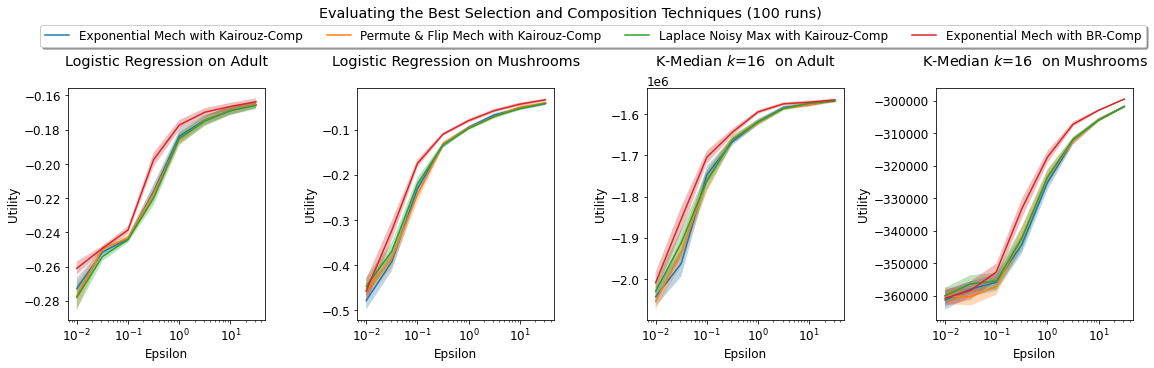

<Figure size 432x288 with 0 Axes>

In [61]:
ci_dict = get_results_and_dump('Selection_Experiment/', 'ga', 'selection.p', problems=['LR','KM_16'])
epsilons = GENS_EPS
nice_names = {'KM_16':'K-Median $k$=16 ', 'LR':'Logistic Regression'}
nice_select = {'gumbel':'Exponential Mech', 'permflip':'Permute & Flip Mech', 'noisym': 'Laplace Noisy Max'}
nice_comp = {'br': 'BR-Comp', 'kairouz': 'Kairouz-Comp'}
plt.rcParams.update({'font.size': 12})
subplot_config = [('Adult', 'LR'), ('Mushrooms', 'LR'), ('Adult', 'KM_16'), ('Mushrooms', 'KM_16')]
fig, axs = plt.subplots(nrows=1,ncols=len(DATASETS), figsize=(16,5))
fig.suptitle("Evaluating the Best Selection and Composition Techniques (100 runs)", y=1.02)
for i in range(4):
    dataset, problem = subplot_config[i]
    for select, comp in [('gumbel', 'kairouz'), ('permflip','kairouz'), ('noisym','kairouz'), ('gumbel', 'br')]:
        result = ci_dict[dataset+problem][select][comp]
        values = [result[str(eps)][0] for eps in epsilons]
        axs[i].semilogx(epsilons, values, label='{} with {}'.format(nice_select[select], nice_comp[comp]))
        lower = [result[str(eps)][1] for eps in epsilons]
        upper = [result[str(eps)][2] for eps in epsilons]
        axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
    axs[i].set_title("{} on {}\n".format(nice_names[problem],dataset))
    axs[i].set_xlabel("Epsilon")
    axs[i].set_ylabel("Utility")
fig.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.97),
        fancybox=True, shadow=True, borderaxespad=0, ncol=4)
plt.plot()
plt.savefig('Plots/Sup_plots/selection_utility_all.png',  bbox_inches='tight')
plt.show()
plt.clf()

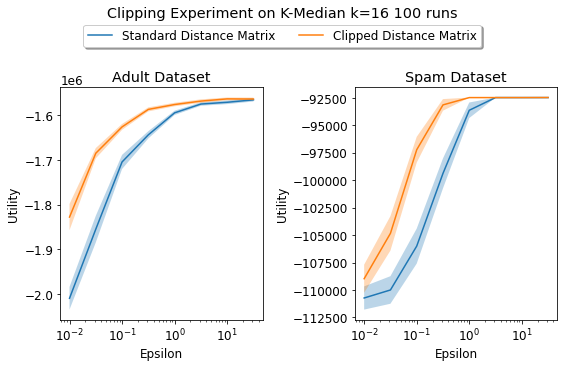

<Figure size 432x288 with 0 Axes>

In [62]:
ci_dict = get_results_and_dump('Utility_Experiment/', 'ga', 'clipping.p', problems=['KM_16'])
epsilons = GENS_EPS
plt.rcParams.update({'font.size': 12})
nice_names = {'LR': 'Logistic Regression', 'KM_4':'K-Median k=4 ', 'KM_16':'K-Median k=16'}
line_labels={'std': 'Standard Distance Matrix', 'clip': 'Clipped Distance Matrix'}
for problem in ['KM_16']:
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
    fig.suptitle("Clipping Experiment on {} 100 runs\n".format(nice_names[problem]), y=1.02)
    for i, dataset in enumerate(['Adult', 'Spam']):
        for util_func in ['std',  'clip']:
            result = ci_dict[dataset+problem][util_func]
            values = [result[str(eps)][0] for eps in epsilons]
            axs[i].semilogx(epsilons, values, label=line_labels[util_func])
            lower = [result[str(eps)][1] for eps in epsilons]
            upper = [result[str(eps)][2] for eps in epsilons]
            axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
        axs[i].set_title("{} Dataset".format(dataset))
        axs[i].set_xlabel("Epsilon")
        axs[i].set_ylabel("Utility")
    fig.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.50, 0.97),
          fancybox=True, shadow=True, borderaxespad=0, ncol=2)
    plt.plot()
    plt.savefig('Plots/Sup_plots/utility_best_{}.png'.format(problem), bbox_inches='tight')
    plt.show()
    plt.clf()

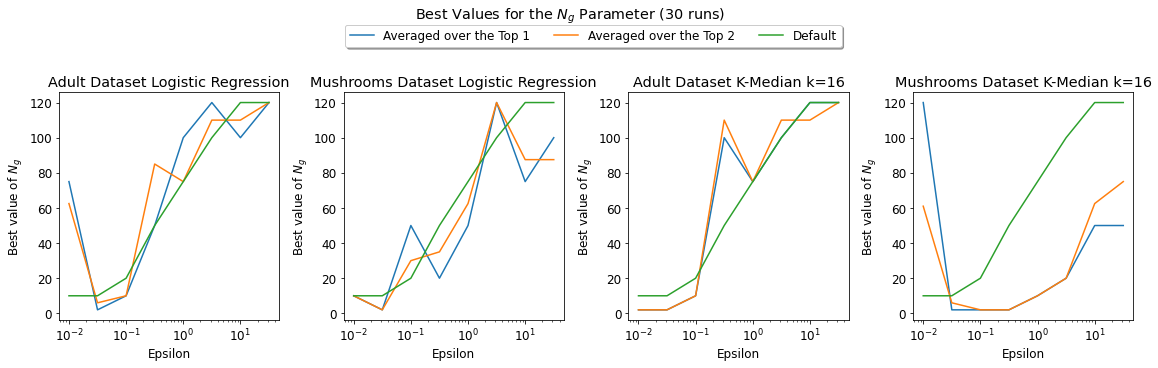

<Figure size 432x288 with 0 Axes>

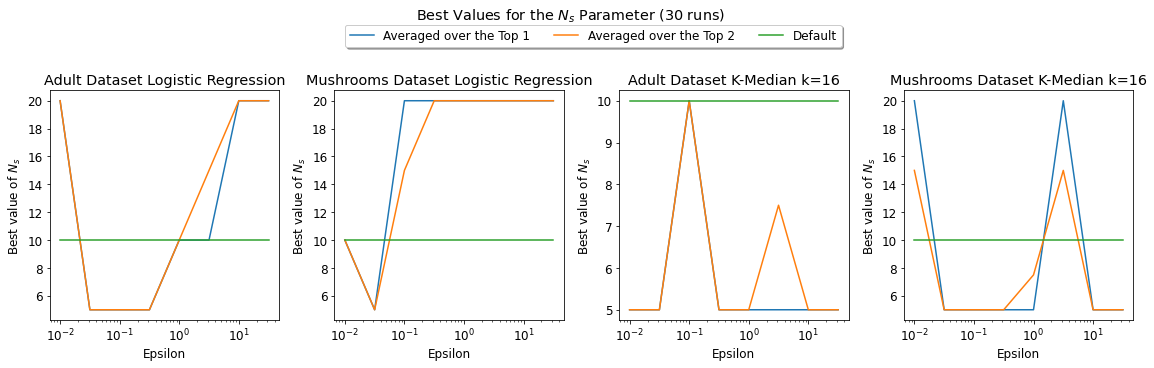

<Figure size 432x288 with 0 Axes>

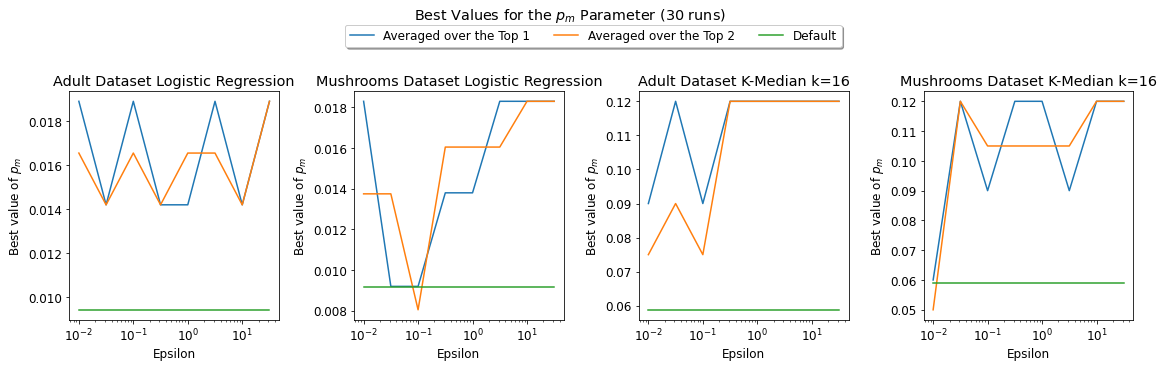

<Figure size 432x288 with 0 Axes>

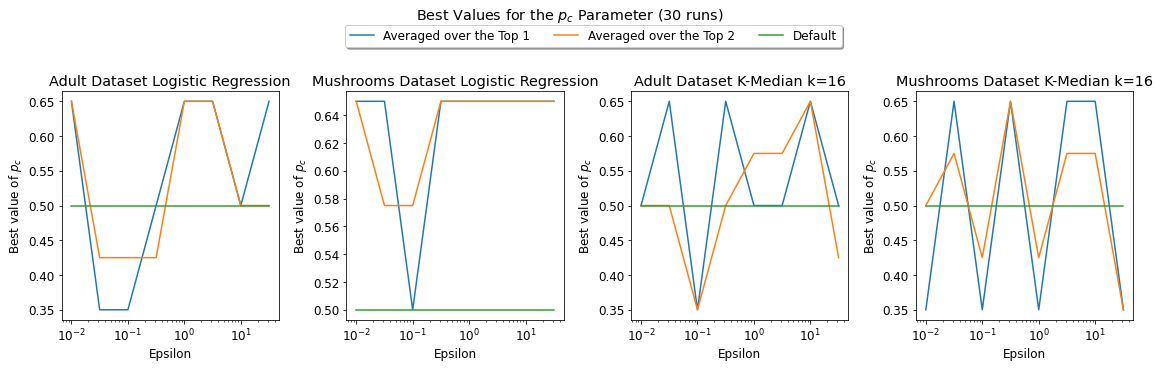

<Figure size 432x288 with 0 Axes>

In [63]:
ci_dict = get_results_and_dump('Grid_Experiment/', 'ga', 'grid_util_dict.p')
cand_size = 5
plt.rcParams.update({'font.size': 12})
epsilons = GENS_EPS
grid_params = {
    'Generations' : [2, 10, 20, 50, 75, 100, 120],
    'Select_size' : [5, 10 , 20],
    'Mutation_rate' : [2/cand_size, 1.5/cand_size, 1/cand_size, 0.75/cand_size],
    'Crossover_rate' : [0.35, 0.5, 0.65]
}
defaults = {
 'Select_size':10, 'Mutation_rate':0.1, 'Crossover_rate':0.5
}
nice_names = {'LR': 'Logistic Regression', 'KM_4':'K-Median k=4 ', 'KM_16':'K-Median k=16'}
param_names = {'Generations': '$N_g$', 'Select_size': '$N_s$', 'Mutation_rate': '$p_m$', 'Crossover_rate': '$p_c$'}
subplot_config = [('Adult', 'LR'), ('Mushrooms', 'LR'), ('Adult', 'KM_16'), ('Mushrooms', 'KM_16')]
for param_idx, param in enumerate(['Generations', 'Select_size', 'Mutation_rate', 'Crossover_rate']):
    fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(16,5))
    fig.suptitle("Best Values for the {} Parameter (30 runs)\n".format(param_names[param]), y=1.02)
    for i in range(4):
        dataset, problem = subplot_config[i]
        #Best results
        for k in [1, 2]:
            filter_vec = [None] * 5
            best_per_gen = []
            for eps in epsilons:
                filter_vec[-1] = str(eps)
                best_per_gen.append(get_top_k(ci_dict[dataset+problem], k = k, restriction=filter_vec))
            param_values = [[float(x[0][param_idx]) for x in best] for best in best_per_gen]
            values = [np.mean(x) for x in param_values]
            axs[i].semilogx(epsilons, values, label='Averaged over the Top {}'.format(k))
        cand_size = utils[dataset+problem].cand_size + 1
        defaults['Mutation_rate'] = 1/cand_size
        if param =='Generations':
            axs[i].semilogx(epsilons, [10, 10, 20, 50, 75, 100, 120, 120], label='Default')
        else:
            axs[i].semilogx(epsilons, [defaults[param]] * len(epsilons), label='Default')
        axs[i].set_title("{} Dataset {}".format(dataset, nice_names[problem]))
        axs[i].set_xlabel("Epsilon")
        axs[i].set_ylabel("Best value of {}".format(param_names[param]))
    fig.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.97),
        fancybox=True, shadow=True, borderaxespad=0, ncol=4)
    plt.plot()
    plt.savefig('Plots/Sup_plots/grid_best_{}.png'.format(param), bbox_inches='tight')
    fig.tight_layout()
    plt.show()
    plt.clf()

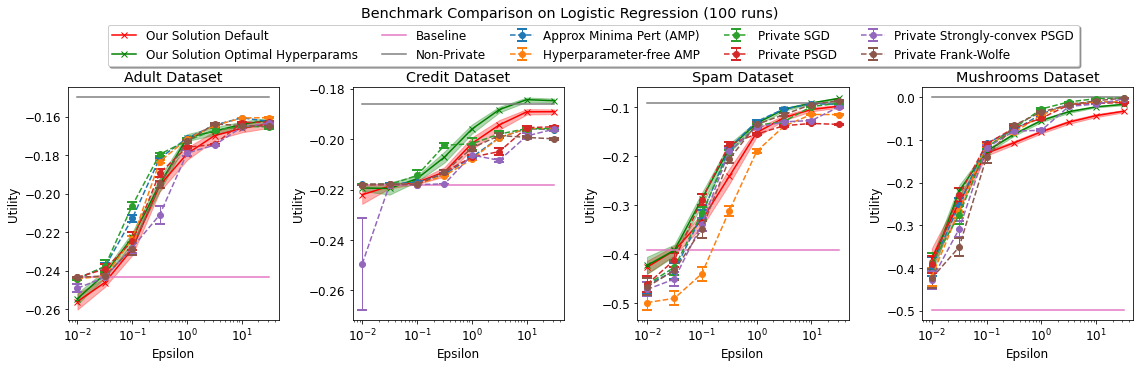

<Figure size 432x288 with 0 Axes>

In [64]:
#Benchmark plot for supplement
epsilons = GENS_EPS
nice_names = {'KM_4':'$k$-Median $k=4$', 'KM_16':'$k$-Median $k=16$','LR':'Logistic Regression'}
for problem in ['LR']:
    fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(16,5))
    fig.suptitle("Benchmark Comparison on {} (100 runs)\n".format(nice_names[problem]), y=1.02)
    for i, dataset in enumerate(DATASETS):
        accuracy_location = './Result_Dicts/LR/ALL_{}.acc'.format(dataset)
        stddev_location = './Result_Dicts/LR/ALL_{}.std'.format(dataset)
        eps_list = GENS_EPS
        w = len(eps_list)

        accuracy_list = np.loadtxt(accuracy_location, delimiter=',')[:,:w]
        accuracy_list = accuracy_list - 1
        stddev_list = np.loadtxt(stddev_location, delimiter=',')[:,:w]

        name_list = ['Non-private baseline',
                    'Approx Minima Pert (AMP)',
                    'Hyperparameter-free AMP',
                    'Private SGD',
                    'Private PSGD',
                    'Private Strongly-convex PSGD',
                    'Private Frank-Wolfe']

        algs_used = [1,2,3,4,5,6]    

        n = accuracy_list.shape[0]

        for j in algs_used:
            axs[i].errorbar(eps_list, accuracy_list[j], yerr=stddev_list[j], label=name_list[j], capsize=5, capthick=2, elinewidth=1, linestyle='dashed', marker='o')

        axs[i].semilogx(epsilons, our_best['default'][dataset+problem][0][:-1], label='Our Solution Default', color='red', marker='x')
        axs[i].fill_between(epsilons, our_best['default'][dataset+problem][1][:-1], our_best['default'][dataset+problem][2][:-1], alpha=0.3, color='red')
        axs[i].semilogx(epsilons, our_best['optimal'][dataset+problem][0][:-1], label='Our Solution Optimal Hyperparams', color='green', marker='x')
        axs[i].fill_between(epsilons, our_best['optimal'][dataset+problem][1][:-1], our_best['optimal'][dataset+problem][2][:-1], alpha=0.3, color='green')
        axs[i].semilogx(epsilons, [baseline[dataset+problem]] * len(epsilons), label='Baseline')
        axs[i].semilogx(epsilons, [non_priv_baseline[dataset+problem]] * len(epsilons), label='Non-Private')
        axs[i].set_title("{} Dataset".format(dataset))
        axs[i].set_xlabel("Epsilon")
        axs[i].set_ylabel("Utility")
    fig.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.97),
        fancybox=True, shadow=True, borderaxespad=0, ncol=5)
    plt.plot()
    plt.savefig('Plots/Sup_plots/benchmark_{}.png'.format(problem), bbox_inches='tight')
    fig.tight_layout()
    plt.show()
    plt.clf()

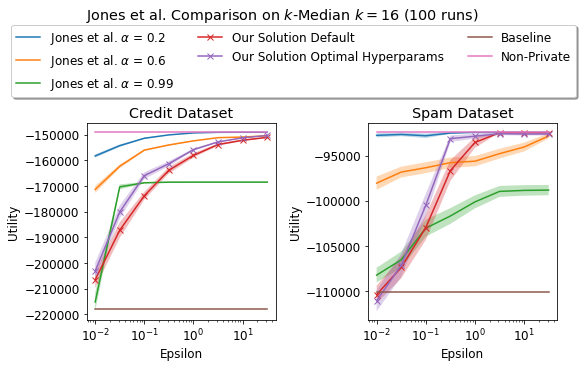

<Figure size 432x288 with 0 Axes>

In [65]:
#Jones missing graphs
jones_ci_dict = get_results_and_dump('Jones/', 'jones', 'Jones.p', problems=['KM_4', 'KM_16'], bug=True, simple=True)
plt.rcParams.update({'font.size': 12})
epsilons = GENS_EPS
nice_names = {'KM_4':'$k$-Median $k=4$', 'KM_16':'$k$-Median $k=16$','LR':'Logistic Regression'}

for problem in ['KM_16']:
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
    fig.suptitle("Jones et al. Comparison on {} (100 runs)\n\n\n".format(nice_names[problem]), y=1.02)
    for i, dataset in enumerate(['Credit', 'Spam']):
        for gens in [0.2, 0.6, 0.99]:
            result = jones_ci_dict[dataset+problem][str(gens)]
            values = [result[str(eps)][0] for eps in epsilons]
            axs[i].semilogx(epsilons, values, label=r'Jones et al. $\alpha$ = {}'.format(gens))
            lower = [result[str(eps)][1] for eps in epsilons]
            upper = [result[str(eps)][2] for eps in epsilons]
            axs[i].fill_between(epsilons, lower, upper, alpha=0.3)

        axs[i].semilogx(epsilons, our_best['default'][dataset+problem][0][:-1], label='Our Solution Default', marker='x')
        axs[i].fill_between(epsilons, our_best['default'][dataset+problem][1][:-1], our_best['default'][dataset+problem][2][:-1], alpha=0.3)
        axs[i].semilogx(epsilons, our_best['optimal'][dataset+problem][0][:-1], label='Our Solution Optimal Hyperparams', marker='x')
        axs[i].fill_between(epsilons, our_best['optimal'][dataset+problem][1][:-1], our_best['optimal'][dataset+problem][2][:-1], alpha=0.3)
        axs[i].semilogx(epsilons, [baseline[dataset+problem]] * len(epsilons), label='Baseline')
        axs[i].semilogx(epsilons, [non_priv_baseline[dataset+problem]] * len(epsilons), label='Non-Private')
        axs[i].set_title("{} Dataset".format(dataset))
        axs[i].set_xlabel("Epsilon")
        axs[i].set_ylabel("Utility")
    fig.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.97),
          fancybox=True, shadow=True, borderaxespad=0, ncol=3)
    plt.plot()
    plt.savefig('Plots/Sup_plots/jones_small.png', bbox_inches='tight')
    fig.tight_layout()
    plt.show()
    plt.clf()

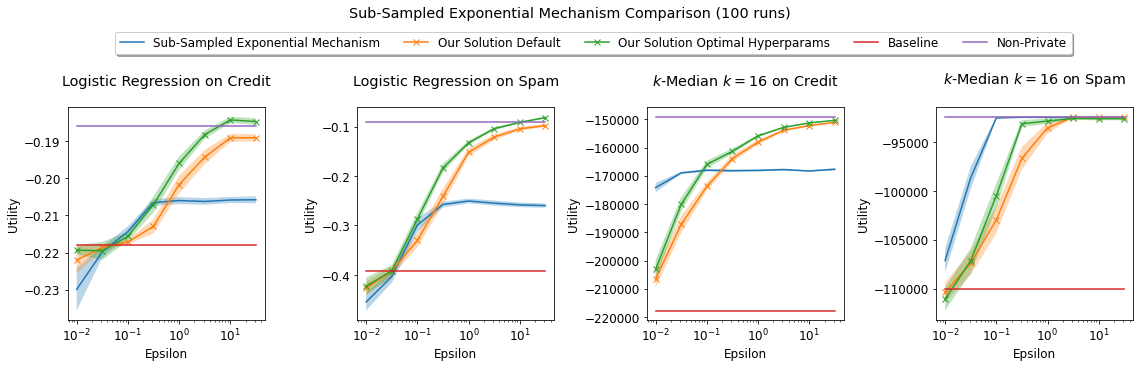

<Figure size 432x288 with 0 Axes>

In [66]:
plt.rcParams.update({'font.size': 12})
epsilons = GENS_EPS
nice_names = {'KM_4':'$k$-Median $k=4$', 'KM_16':'$k$-Median $k=16$','LR':'Logistic Regression'}
with open('Result_Dicts/subsampled_exp_mech.p', 'rb') as input_file:
            sub_samp = pickle.load(input_file)
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(16,5))
fig.suptitle("Sub-Sampled Exponential Mechanism Comparison (100 runs)\n", y=1.02)
subplot_config = [('Credit', 'LR'), ('Spam', 'LR'), ('Credit', 'KM_16'), ('Spam', 'KM_16')]
for i in range(4):
    dataset, problem = subplot_config[i]
    result = sub_samp[dataset+problem]
    values = [result[str(eps)][0] for eps in epsilons]
    axs[i].semilogx(epsilons, values, label='Sub-Sampled Exponential Mechanism')
    lower = [result[str(eps)][1] for eps in epsilons]
    upper = [result[str(eps)][2] for eps in epsilons]
    axs[i].fill_between(epsilons, lower, upper, alpha=0.3)
    axs[i].semilogx(epsilons, our_best['default'][dataset+problem][0][:-1], label='Our Solution Default', marker='x')
    axs[i].fill_between(epsilons, our_best['default'][dataset+problem][1][:-1], our_best['default'][dataset+problem][2][:-1], alpha=0.3)
    axs[i].semilogx(epsilons, our_best['optimal'][dataset+problem][0][:-1], label='Our Solution Optimal Hyperparams', marker='x')
    axs[i].fill_between(epsilons, our_best['optimal'][dataset+problem][1][:-1], our_best['optimal'][dataset+problem][2][:-1], alpha=0.3)
    axs[i].semilogx(epsilons, [baseline[dataset+problem]] * len(epsilons), label='Baseline')
    axs[i].semilogx(epsilons, [non_priv_baseline[dataset+problem]] * len(epsilons), label='Non-Private')
    axs[i].set_title("{} on {}\n".format(nice_names[problem],dataset))
    axs[i].set_xlabel("Epsilon")
    axs[i].set_ylabel("Utility")
fig.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.95),
    fancybox=True, shadow=True, borderaxespad=0, ncol=5)
plt.plot()
plt.savefig('Plots/Sup_plots/sub_sampled_small.png', bbox_inches='tight')
fig.tight_layout()
plt.show()
plt.clf()

Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files
Loaded 1800 files


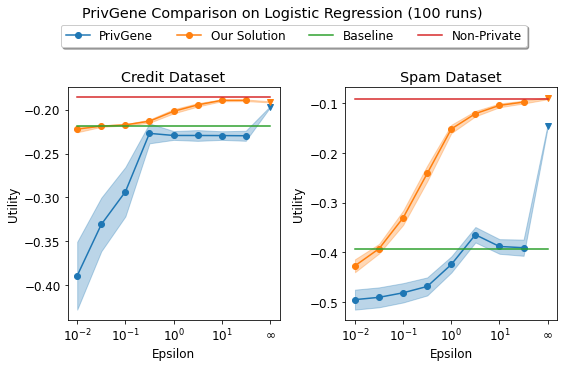

<Figure size 432x288 with 0 Axes>

In [67]:
#------------------PrivGene vs Us Utility paper---------------------------
epsilons = GENS_EPS + [-1]
eps_to_plot = GENS_EPS + [100]
PrivGene_results = get_results_and_dump('PrivGene_Experiment/', 'PrivGene', 'PrivGene.p')
Our_results = get_results_and_dump('Grid_Final/', 'ga', 'Final_Grid.p')
plt.rcParams.update({'font.size': 12})
nice_names = {'KM_4':'$k$-Median $k=4$', 'KM_16':'$k$-Median $k=16$','LR':'Logistic Regression'}
for problem in ['LR']:
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
    fig.suptitle("PrivGene Comparison on {} (100 runs)\n".format(nice_names[problem]), y=1.02)
    for i, dataset in enumerate(['Credit', 'Spam']):
        result = PrivGene_results[dataset+problem]['std']['0']
        values = [result[str(eps)][0] for eps in epsilons]
        color = next(axs[i]._get_lines.prop_cycler)['color']
        axs[i].semilogx(eps_to_plot[:-1], values[:-1], label='PrivGene',color=color, marker='o')
        axs[i].semilogx(eps_to_plot[-1], values[-1],linestyle='None', marker='v',color=color)
        lower = [result[str(eps)][1] for eps in epsilons]
        upper = [result[str(eps)][2] for eps in epsilons]
        axs[i].fill_between(eps_to_plot, lower, upper, alpha=0.3,color=color)
        
        result = Our_results[dataset+problem]['std']
        values = [result[str(eps)][0] for eps in epsilons]
        color = next(axs[i]._get_lines.prop_cycler)['color']
        axs[i].semilogx(eps_to_plot[:-1], values[:-1], label='Our Solution',color=color, marker='o')
        axs[i].semilogx(eps_to_plot[-1], values[-1],color=color,linestyle='None', marker='v')
        lower = [result[str(eps)][1] for eps in epsilons]
        upper = [result[str(eps)][2] for eps in epsilons]
        axs[i].fill_between(eps_to_plot, lower, upper, color=color,alpha=0.3)
        axs[i].semilogx(eps_to_plot, [baseline[dataset+problem]] * len(eps_to_plot), label='Baseline')
        axs[i].semilogx(eps_to_plot, [non_priv_baseline[dataset+problem]] * len(eps_to_plot), label='Non-Private')
        axs[i].set_xticks([0.01, 0.1, 1.0, 10.0, 100.0])
        axs[i].set_xticklabels(['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$', '$\infty$'])
        axs[i].set_title("{} Dataset".format(dataset))
        axs[i].set_xlabel("Epsilon")
        axs[i].set_ylabel("Utility")
    fig.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.97),
        fancybox=True, shadow=True, borderaxespad=0, ncol=6)
    plt.plot()
    plt.savefig('Plots/Sup_plots/privGene_comparison_small.png', bbox_inches='tight')
    fig.tight_layout()
    plt.show()
    plt.clf()

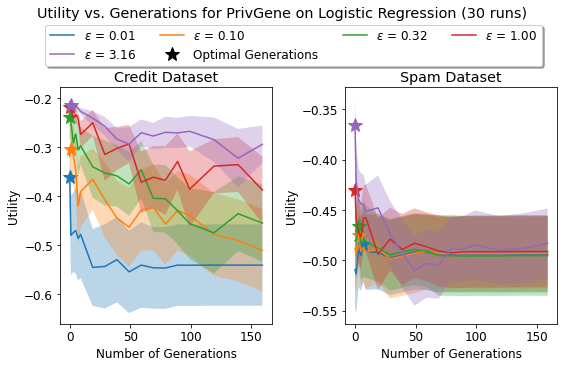

<Figure size 432x288 with 0 Axes>

In [68]:
#----------------Iterations plot for sup privgene-----------------------
priv_gene_gens_dict = get_results_and_dump('Generations_Experiment_PG/', 'PrivGene', 'PG_Generations.p', problems=['LR'])
epsilons = [0.01, 0.1, 0.316227766017, 1, 3.16227766017]
plt.rcParams.update({'font.size': 12})
nice_names = {'LR': 'Logistic Regression', 'KM_4':'K-Median k=4 ', 'KM_16':'K-Median k=16'}
iterations = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160]
it_to_plot = [x-1 for x in iterations]
for problem in ['LR']:
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
    fig.suptitle("Utility vs. Generations for PrivGene on {} (30 runs)\n".format(nice_names[problem]), y=1.02)
    for i, dataset in enumerate(['Credit', 'Spam']):
        for epsilon in epsilons:
            results = priv_gene_gens_dict[dataset+problem]
            to_plot = [results[str(iter)][str(epsilon)] for iter in iterations]

            values = [result[0] for result in to_plot]
            max = np.argmax(values)
            color = next(axs[i]._get_lines.prop_cycler)['color']
            axs[i].plot(it_to_plot, values, label='$\epsilon$ = {:.2f}'.format(epsilon), color=color)
            axs[i].plot(it_to_plot[max], values[max], color=color, marker='*', markersize='15')
            lower = [result[1] for result in to_plot]
            upper = [result[2] for result in to_plot]
            axs[i].fill_between(it_to_plot, lower, upper, alpha=0.3)


            axs[i].set_title("{} Dataset".format(dataset))
            axs[i].set_xlabel("Number of Generations")
            axs[i].set_ylabel("Utility")
    fig.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    line = Line2D([], [], color='black', marker='*', markersize='15', label='Optimal Generations', linestyle='None')
    handles.append(line)
    labels.append('Optimal Generations')
    def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])
    fig.legend(flip(handles, 4), flip(labels, 4), loc='upper center', bbox_to_anchor=(0.52, 0.97),
          fancybox=True, shadow=True, borderaxespad=0, ncol=4)
    plt.plot()
    plt.savefig('Plots/Sup_plots/generations_PG_small.png', bbox_inches='tight')
    plt.show()
    plt.clf()

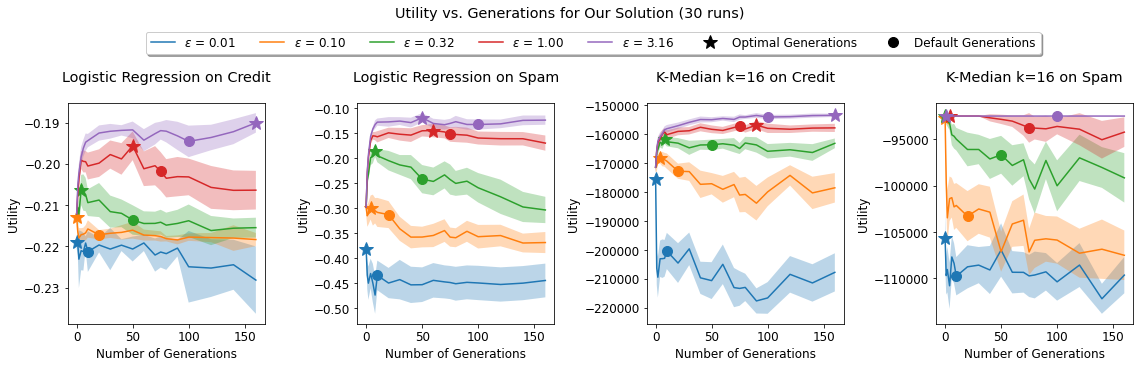

<Figure size 432x288 with 0 Axes>

In [69]:
#-------------------Iteration Plots for sup--------------------------------
from matplotlib.lines import Line2D
our_gens_dict = get_results_and_dump('Generations_Experiment/', 'ga', 'Our_Generations.p')
epsilons = [0.01, 0.1, 0.316227766017, 1, 3.16227766017]
plt.rcParams.update({'font.size': 12})
nice_names = {'LR': 'Logistic Regression', 'KM_4':'K-Median k=4 ', 'KM_16':'K-Median k=16'}
iterations = [0, 1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 120, 140, 160]
gens_mapping = { '0.01': '10',
                '0.0316227766017': '10',
                '0.1': '20',
                '0.316227766017' : '50',
                '1' : '75',
                '3.16227766017' : '100',
                '10' : '120',
                '31.6227766017' : '120'}

fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(16,5))
fig.suptitle("Utility vs. Generations for Our Solution (30 runs)\n", y=1.02)
subplot_config = [('Credit', 'LR'), ('Spam', 'LR'), ('Credit', 'KM_16'), ('Spam', 'KM_16')]
for i in range(4):
    dataset, problem = subplot_config[i]
    for epsilon in epsilons:
        results = our_gens_dict[dataset+problem]
        to_plot = [results[str(iter)][str(epsilon)] for iter in iterations]

        values = [result[0] for result in to_plot]
        max = np.argmax(values)
        default = iterations.index(int(gens_mapping[str(epsilon)]))
        color = next(axs[i]._get_lines.prop_cycler)['color']
        axs[i].plot(iterations, values, label='$\epsilon$ = {:.2f}'.format(epsilon), color=color)
        axs[i].plot(iterations[max], values[max], color=color, marker='*', markersize='15')
        axs[i].plot(iterations[default], values[default], color=color, marker='o', markersize='10')
        lower = [result[1] for result in to_plot]
        upper = [result[2] for result in to_plot]
        axs[i].fill_between(iterations, lower, upper, alpha=0.3)


        axs[i].set_title("{} on {}\n".format(nice_names[problem],dataset))
        axs[i].set_xlabel("Number of Generations")
        axs[i].set_ylabel("Utility")
fig.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
line = Line2D([], [], color='black', marker='*', markersize='15', label='Optimal Generations', linestyle='None')
handles.append(line)
labels.append('Optimal Generations')
line = Line2D([], [], color='black', marker='o', markersize='10', label='Default Generations',linestyle='None')
handles.append(line)
labels.append('Default Generations')
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.95),
        fancybox=True, shadow=True, borderaxespad=0, ncol=7)
plt.plot()
plt.savefig('Plots/Sup_plots/generations_us_small.png', bbox_inches='tight')
plt.show()
plt.clf()